In [132]:
import  scipy.signal.signaltools

def _centered(arr, newsize):
    # Return the center newsize portion of the array.
    newsize = np.asarray(newsize)
    currsize = np.array(arr.shape)
    startind = (currsize - newsize) // 2
    endind = startind + newsize
    myslice = [slice(startind[k], endind[k]) for k in range(len(endind))]
    return arr[tuple(myslice)]

scipy.signal.signaltools._centered = _centered

In [162]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
from patsy import dmatrix
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, mean_absolute_error, mean_squared_error, r2_score, roc_curve, auc, precision_score, recall_score, confusion_matrix
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeRegressor,DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, ParameterGrid, RandomizedSearchCV
from sklearn.ensemble import BaggingRegressor,BaggingClassifier,RandomForestRegressor,RandomForestClassifier
from sklearn.ensemble import VotingRegressor, StackingRegressor
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt


# suppressing warnings
import warnings
warnings.filterwarnings("ignore")

In [137]:
vaccine_data = pd.read_csv('data/COVID-19_Vaccinations_in_the_United_States_Jurisdiction_20240111.csv')
death_data = pd.read_csv('data/deaths_with_abbs.csv')
data1 = pd.read_csv('data/covid_deaths2.csv')
data = pd.read_csv('data/merged_clean.csv')
data 

,date.x,state,location,year,month.x,mmwr_week,covid_19_deaths,date.y,distributed,distributed_janssen,...,bivalent_booster_12plus_pop_pct,bivalent_booster_18plus,bivalent_booster_18plus_pop_pct,bivalent_booster_65plus,bivalent_booster_65plus_pop_pct,month.y,day_of_week,region,month,season
0,2020-01-04,Alabama,AL,2020,1,1,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,South,1,Winter
1,2020-01-11,Alabama,AL,2020,1,2,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,South,1,Winter
2,2020-01-18,Alabama,AL,2020,1,3,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,South,1,Winter
3,2020-01-25,Alabama,AL,2020,1,4,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,South,1,Winter
4,2020-02-01,Alabama,AL,2020,2,5,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,South,2,Winter
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10915,2023-12-09,Puerto Rico,PR,2023,12,49,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Puerto Rico,12,Winter
10916,2023-12-16,Puerto Rico,PR,2023,12,50,12.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Puerto Rico,12,Winter
10917,2023-12-23,Puerto Rico,PR,2023,12,51,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Puerto Rico,12,Winter
10918,2023-12-30,Puerto Rico,PR,2023,12,52,15.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Puerto Rico,12,Winter


# Dropping Data

In [138]:
data = data.drop(['date.y', 'month.x', 'state','month.y', 'day_of_week'], axis=1) 
data = data.dropna(subset=['covid_19_deaths'])  

In [139]:
data 

,date.x,location,year,mmwr_week,covid_19_deaths,distributed,distributed_janssen,distributed_moderna,distributed_pfizer,distributed_novavax,...,bivalent_booster_5plus_pop_pct,bivalent_booster_12plus,bivalent_booster_12plus_pop_pct,bivalent_booster_18plus,bivalent_booster_18plus_pop_pct,bivalent_booster_65plus,bivalent_booster_65plus_pop_pct,region,month,season
0,2020-01-04,AL,2020,1,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,South,1,Winter
1,2020-01-11,AL,2020,2,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,South,1,Winter
2,2020-01-18,AL,2020,3,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,South,1,Winter
4,2020-02-01,AL,2020,5,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,South,2,Winter
5,2020-02-08,AL,2020,6,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,South,2,Winter
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10910,2023-11-04,PR,2023,44,14.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Puerto Rico,11,Fall
10911,2023-11-11,PR,2023,45,10.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Puerto Rico,11,Fall
10914,2023-12-02,PR,2023,48,13.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Puerto Rico,12,Winter
10916,2023-12-16,PR,2023,50,12.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Puerto Rico,12,Winter


In [166]:
data = pd.read_csv('data/merged_cleaned_processed.csv')
data

,Unnamed: 0,date.x,location,year,mmwr_week,covid_19_deaths,date.y,distributed,distributed_janssen,distributed_moderna,...,month,region_East,region_Midwest,region_Puerto Rico,region_South,region_West,season_Fall,season_Spring,season_Summer,season_Winter
0,0,2020-01-04,AL,2020,1,0.0,NaN,0.0,0.0,0.0,...,1,0,0,0,1,0,0,0,0,1
1,3780,2020-01-04,LA,2020,1,0.0,NaN,0.0,0.0,0.0,...,1,0,0,0,1,0,0,0,0,1
2,9660,2020-01-04,VA,2020,1,0.0,NaN,0.0,0.0,0.0,...,1,0,0,0,1,0,0,0,0,1
3,3570,2020-01-04,KY,2020,1,0.0,NaN,0.0,0.0,0.0,...,1,0,0,0,1,0,0,0,0,1
4,3360,2020-01-04,KS,2020,1,0.0,NaN,0.0,0.0,0.0,...,1,0,1,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8944,7559,2024-01-06,OH,2024,1,23.0,NaN,0.0,0.0,0.0,...,1,0,1,0,0,0,0,0,0,1
8945,6929,2024-01-06,NY,2024,1,145.0,NaN,0.0,0.0,0.0,...,1,1,0,0,0,0,0,0,0,1
8946,6509,2024-01-06,NJ,2024,1,39.0,NaN,0.0,0.0,0.0,...,1,1,0,0,0,0,0,0,0,1
8947,6299,2024-01-06,NH,2024,1,12.0,NaN,0.0,0.0,0.0,...,1,1,0,0,0,0,0,0,0,1


#  Correlation

In [155]:
correlations = data.corrwith(data["covid_19_deaths"])
correlations_df = pd.DataFrame({'feature': correlations.index, 'correlation': correlations.values})
correlations_df.sort_values(by = ['correlation'], ascending = False)

,feature,correlation
3,covid_19_deaths,1.000000
74,additional_doses_5plus,0.626565
91,second_booster_65plus,0.607488
89,second_booster_50plus,0.585957
93,second_booster_janssen,0.568839
...,...,...
28,admin_per_100k_18plus,-0.247874
40,administered_dose1_recip_65plus_pop_pct,-0.261466
50,series_complete_65plus_pop_pct,-0.265322
29,admin_per_100k_65plus,-0.273770


In [145]:
# Remove constant features
constant_features = data.columns[data.nunique() == 1]
print(constant_features)

Index([], dtype='object')


In [156]:
#remove redundant features
corr_matrix = data.corr().abs()
upper_triangle = np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
correlated_columns = [column for column in corr_matrix.columns if any(corr_matrix[column] > 0.5)]

In [157]:
correlated_columns

['Unnamed: 0',
 'year',
 'mmwr_week',
 'covid_19_deaths',
 'distributed',
 'distributed_janssen',
 'distributed_moderna',
 'distributed_pfizer',
 'distributed_novavax',
 'distributed_unk_manuf',
 'dist_per_100k',
 'distributed_per_100k_5plus',
 'distributed_per_100k_12plus',
 'distributed_per_100k_18plus',
 'distributed_per_100k_65plus',
 'administered',
 'administered_5plus',
 'administered_12plus',
 'administered_18plus',
 'administered_65plus',
 'administered_janssen',
 'administered_moderna',
 'administered_pfizer',
 'administered_novavax',
 'administered_unk_manuf',
 'admin_per_100k',
 'admin_per_100k_5plus',
 'admin_per_100k_12plus',
 'admin_per_100k_18plus',
 'admin_per_100k_65plus',
 'recip_administered',
 'administered_dose1_recip',
 'administered_dose1_pop_pct',
 'administered_dose1_recip_5plus',
 'administered_dose1_recip_5plus_pop_pct',
 'administered_dose1_recip_12plus',
 'administered_dose1_recip_12plus_pop_pct',
 'administered_dose1_recip_18plus',
 'administered_dose1_re

In [158]:
print("Correlation Matrix:")
print(corr_matrix)

Correlation Matrix:
                   Unnamed: 0      year  mmwr_week  covid_19_deaths  \
Unnamed: 0           1.000000  0.011262   0.009989         0.036129   
year                 0.011262  1.000000   0.033363         0.159780   
mmwr_week            0.009989  0.033363   1.000000         0.003123   
covid_19_deaths      0.036129  0.159780   0.003123         1.000000   
distributed          0.047602  0.303141   0.038266         0.134438   
...                       ...       ...        ...              ...   
date.y_2023-04-12    0.003300  0.093585   0.047393         0.022391   
date.y_2023-04-19    0.005054  0.091010   0.042090         0.021694   
date.y_2023-04-26    0.003318  0.091010   0.038091         0.022681   
date.y_2023-05-03    0.000050  0.089696   0.033600         0.022971   
date.y_2023-05-10    0.005345  0.079899   0.026420         0.020116   

                   distributed  distributed_janssen  distributed_moderna  \
Unnamed: 0            0.047602             0.051534

In [159]:
correlation_matrix = data.corr()['covid_19_deaths']
print("Correlation Matrix with Target Variable:")
print(correlation_matrix)

Correlation Matrix with Target Variable:
Unnamed: 0          -0.036129
year                -0.159780
mmwr_week            0.003123
covid_19_deaths      1.000000
distributed          0.134438
                       ...   
date.y_2023-04-12   -0.022391
date.y_2023-04-19   -0.021694
date.y_2023-04-26   -0.022681
date.y_2023-05-03   -0.022971
date.y_2023-05-10   -0.020116
Name: covid_19_deaths, Length: 301, dtype: float64


<AxesSubplot:>

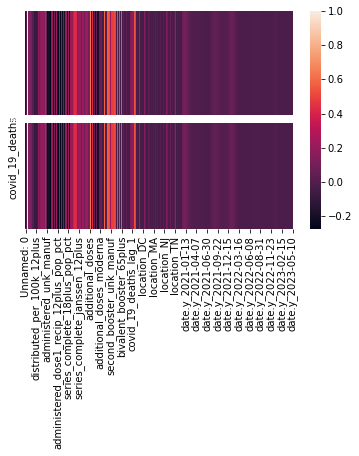

In [168]:
correlation_df = pd.DataFrame(correlation_matrix)
sns.heatmap(correlation_df.transpose(), annot=True)

# Lag + Rolling Mean 

In [151]:
import pandas as pd

# Assuming 'result_data' contains your dataset with a column named 'Covid19_deaths'
# Sort the DataFrame by 'End Date' if it's not already sorted
data.sort_values(by='date.x', inplace=True)

# Lag features
num_lags = 3  # Number of lag features
for i in range(1, num_lags + 1):
    data[f'covid_19_deaths_lag_{i}'] = data['covid_19_deaths'].shift(i)

# Rolling statistics
window_size = 7  # Rolling window size
data['rolling_mean'] = data['covid_19_deaths'].rolling(window=window_size).mean()
data['rolling_std'] = data['covid_19_deaths'].rolling(window=window_size).std()

# Print the updated DataFrame to verify the changes
print(data) 

      Unnamed: 0      date.x location  year  mmwr_week  covid_19_deaths  \
0              0  2020-01-04       AL  2020          1              0.0   
28          7770  2020-01-04       OR  2020          1              0.0   
29          7560  2020-01-04       OK  2020          1              0.0   
30          8400  2020-01-04       SC  2020          1              0.0   
31          7350  2020-01-04       OH  2020          1              0.0   
...          ...         ...      ...   ...        ...              ...   
8926        1679  2024-01-06       DE  2024          1              0.0   
8927        1469  2024-01-06       CT  2024          1              0.0   
8928        1049  2024-01-06       CA  2024          1             48.0   
8930         629  2024-01-06       AZ  2024          1             18.0   
8948        6089  2024-01-06       NV  2024          1              0.0   

     date.y  distributed  distributed_janssen  distributed_moderna  ...  \
0       NaN          0.0

# Seasonality

In [167]:
# Assuming 'data' contains your dataset with a DateTime index
# If not, set the index to your DateTime column
data['date.x'] = pd.to_datetime(data['date.x'])
data.set_index('date.x', inplace=True)

# Ensure that the index is a DateTimeIndex
if not isinstance(data.index, pd.DatetimeIndex):
    data.index = pd.to_datetime(data.index)

# Perform seasonal decomposition
decomposition = seasonal_decompose(data['covid_19_deaths'], model='additive')

# Plot the decomposition
plt.figure(figsize=(10, 8))
plt.subplot(4, 1, 1)
plt.plot(data['covid_19_deaths'], label='Original')
plt.legend(loc='upper left')
plt.subplot(4, 1, 2)
plt.plot(decomposition.trend, label='Trend')
plt.legend(loc='upper left')
plt.subplot(4, 1, 3)
plt.plot(decomposition.seasonal, label='Seasonality')
plt.legend(loc='upper left')
plt.subplot(4, 1, 4)
plt.plot(decomposition.resid, label='Residuals')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show() 

ValueError: You must specify a period or x must be a pandas object with a DatetimeIndex with a freq not set to None

In [153]:
# Find the non-binary categorical columns
cat_cols = []
for col in data.columns:
    if data[col].dtype == 'object' and len(data[col].unique()) > 2:
        cat_cols.append(col)
print("Non-binary categorical columns:", cat_cols)

# Create binary columns from the categorical columns
data = pd.get_dummies(data, columns=cat_cols)

# Print the resulting dataframe
print(data.head())

Non-binary categorical columns: ['location', 'date.y']
            Unnamed: 0  year  mmwr_week  covid_19_deaths  distributed  \
date.x                                                                  
2020-01-04           0  2020          1              0.0          0.0   
2020-01-04        7770  2020          1              0.0          0.0   
2020-01-04        7560  2020          1              0.0          0.0   
2020-01-04        8400  2020          1              0.0          0.0   
2020-01-04        7350  2020          1              0.0          0.0   

            distributed_janssen  distributed_moderna  distributed_pfizer  \
date.x                                                                     
2020-01-04                  0.0                  0.0                 0.0   
2020-01-04                  0.0                  0.0                 0.0   
2020-01-04                  0.0                  0.0                 0.0   
2020-01-04                  0.0                  0.0 

In [154]:
#split the target value and the features
y= data['covid_19_deaths']
X= data.drop(['covid_19_deaths'], axis=1) 

#train test split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=45)

#scale the features
scaler = StandardScaler()

scaler.fit(X_train)
scaler.fit(X_test)
scaler_train = scaler.transform(X_train)
scaler_test = scaler.transform(X_test)

def initialize(dim):
    weights = np.full((dim,),0.01)
    bias = 0.0
    return weights, bias 

def predict(model_parameters, X_test):
    weights = model_parameters['bias']
    bias = model_parameters['bias']
    
    y_pred = np.dot(X_test, weights) + bias 
    
    return y_pred